In [1]:
import sys
sys.path.append("../..")
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import random
%matplotlib inline

In [2]:
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from train import train
from train import train_rnis
from models_new import Renorm_Dynamic
from models_new import Rnis_Dynamic
from ei.EI_calculation import count_parameters
from dynamic_models_sis_new import Simple_Spring_Model
from datetime import datetime
t0 = datetime.now()


use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0') if use_cuda else torch.device('cpu')
device

device(type='cuda', index=0)

# Generate data

In [3]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
test_data = spring.generate_multistep_sir(size_list=[500,500], steps=10, sigma=sigma, rou=rou,lam=1,miu=0.5,dt=dt) 
train_data = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt)

# Train RNIS

In [ ]:
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 30001
hidden_units_dyn = 32
eis_rnis, term1s_rnis, term2s_rnis, losses_rnis, MAEs_mstep_rnis, net_rnis = train_rnis(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, hidden_units_dyn = hidden_units_dyn, dt=dt, T2=T_total)

33312
check point-------o_0-> 16:34:22.219974; lasting 0:00:05.909153 seconds
Epoch: 0
Train loss: 0.4543
dEI: 0.8603
term1: 0.2799
term2: 1.4407
Test multistep loss: 0.5179
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:34:30.659683; lasting 0:00:08.439709 seconds
check point-------o_0-> 16:34:41.149832; lasting 0:00:10.490149 seconds
Epoch: 500
Train loss: 0.0550
dEI: 1.5095
term1: 1.5981
term2: 1.4208
Test multistep loss: 0.0531
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 16:34:51.550585; lasting 0:00:10.400753 seconds
check point-------o_0-> 16:35:00.989356; lasting 0:00:09.438771 seconds
Epoch: 1000
Train loss: 0.0354
dEI: 1.7812
term1: 2.1334
term2: 1.4290
Test multistep loss: 0.0335
---------------------------------------------------------------------------------------------------

# Train NIS

In [ ]:
sz = 4
scale = 2
L = 1
mae2_w = 3
T_total = 30001
eis_nis, term1s_nis, term2s_nis, losses_nis, MAEs_mstep_nis, net_nis = train(train_data=train_data, test_data=test_data, 
                                                                    sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                    mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis')

check point-------o_0-> 20:13:26.787224; lasting 0:00:07.928265 seconds
Epoch: 7000
Train loss: 0.0291
dEI: 2.4107
term1: 3.4063
term2: 1.4151
Test multistep loss: 0.0338
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 20:13:37.677312; lasting 0:00:10.890088 seconds
check point-------o_0-> 20:13:45.664396; lasting 0:00:07.987084 seconds
Epoch: 7500
Train loss: 0.0287
dEI: 2.4061
term1: 3.4019
term2: 1.4103
Test multistep loss: 0.0329
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 20:13:57.641781; lasting 0:00:11.977385 seconds
check point-------o_0-> 20:14:05.238831; lasting 0:00:07.597050 seconds
Epoch: 8000
Train loss: 0.0291
dEI: 2.4222
term1: 3.4384
term2: 1.4059
Test multistep loss: 0.0309
-----------------------------------------------------------------------------------------------------

# Train NIS+

In [ ]:
eis_nisp, term1s_nisp, term2s_nisp, losses_nisp, MAEs_mstep_nisp, net_nisp = train(train_data=train_data, test_data=test_data, 
                                                                         sigma=sigma, rou=rou, sz=sz, scale=scale, L=L, 
                                                                         mae2_w=mae2_w, dt=dt, T2=T_total,framework='nis+')

check point-------w_0-> 20:41:24.132636; lasting 0:00:14.351374 seconds
check point-------w_1-> 20:41:24.149588; lasting 0:00:00.016952 seconds
check point-------w_2-> 20:47:09.271608; lasting 0:05:45.122020 seconds
check point-------w_3-> 20:47:09.275393; lasting 0:00:00.003785 seconds
check point-------o_0-> 20:47:09.284679; lasting 0:00:00.009286 seconds
Epoch: 3000
Train loss: 0.0297
dEI: 2.2194
term1: 2.9067
term2: 1.5321
Test multistep loss: 0.0323
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 20:47:19.976757; lasting 0:00:10.692078 seconds
check point-------o_0-> 20:47:40.915845; lasting 0:00:20.939088 seconds
Epoch: 3500
Train loss: 0.0290
dEI: 2.3815
term1: 3.2371
term2: 1.5260
Test multistep loss: 0.0285
------------------------------------------------------------------------------------------------------------------------
check point-------o_1-> 20:47:52.238584; lasting 0:00:11

# Results

In [13]:
print(count_parameters(net_rnis),count_parameters(net_nis),count_parameters(net_nisp))

33312 37404 37428


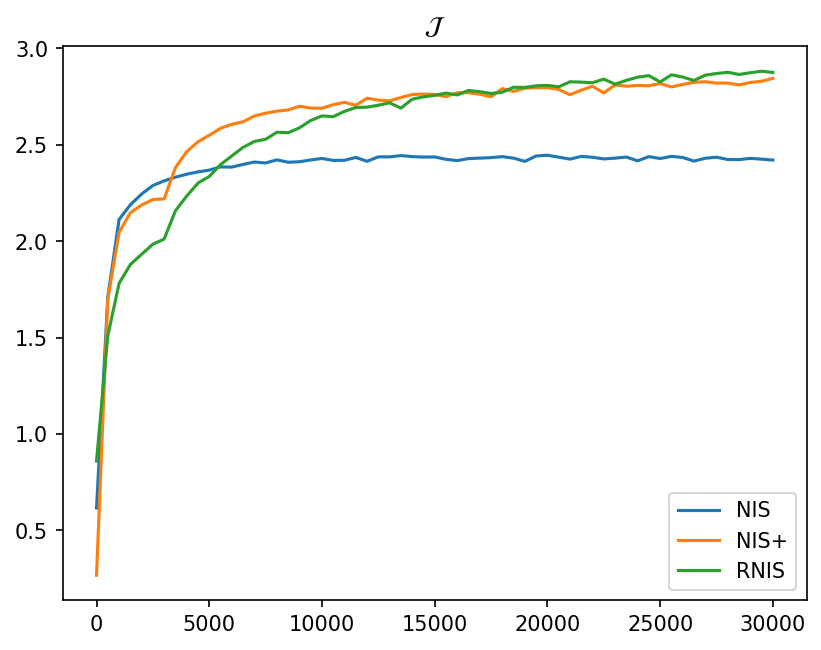

In [14]:
plt.figure(dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, eis_nis, label='NIS')
plt.plot(timeseries, eis_nisp, label='NIS+')
plt.plot(timeseries, eis_rnis, label='RNIS')
plt.title(r'$\mathcal{J}$')
plt.legend()
plt.show()

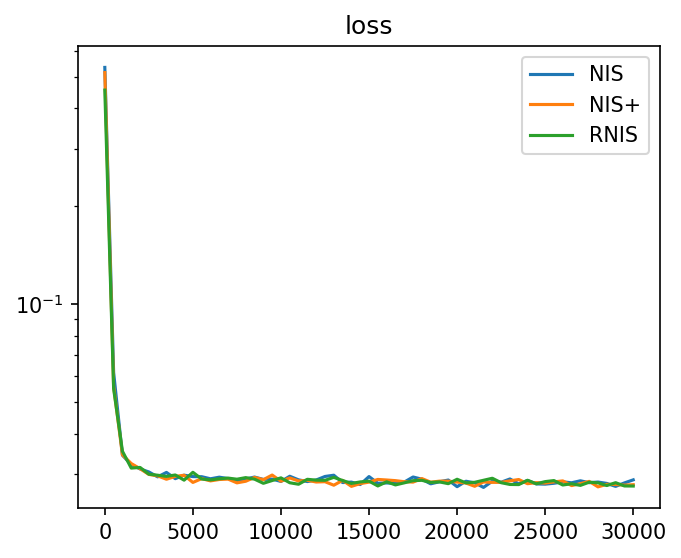

In [15]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, losses_nis, label='NIS')
plt.plot(timeseries, losses_nisp, label='NIS+')
plt.plot(timeseries, losses_rnis, label='RNIS')
plt.title(r'loss')
plt.legend()
plt.yscale('log')
plt.show()

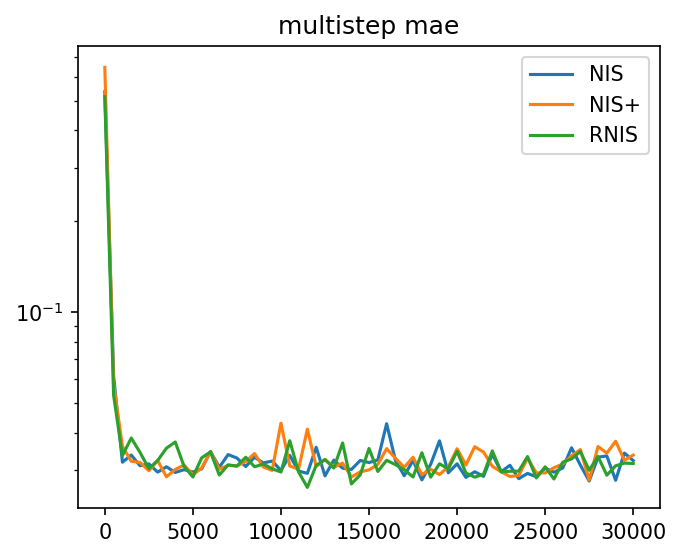

In [16]:
plt.figure(figsize=(5,4),dpi=150)
timeseries = np.arange(len(eis_nis))*500
plt.plot(timeseries, MAEs_mstep_nis, label='NIS')
plt.plot(timeseries, MAEs_mstep_nisp, label='NIS+')
plt.plot(timeseries, MAEs_mstep_rnis, label='RNIS')
plt.title(r'multistep mae')
plt.legend()
plt.yscale('log')
plt.show()

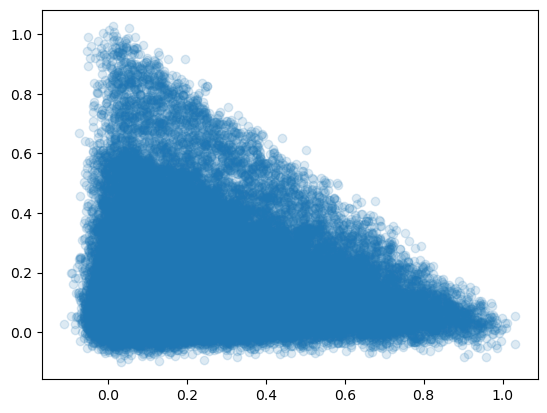

In [19]:
mul_batch_size = [0,5000,3000,1000]#[0,10,4500,1500]
sigma = 0.03
rou = -0.5
steps = 7
interval = 100
dt = 0.01

seed = 2050
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
spring = Simple_Spring_Model(device=device)
ss,_,_,_ = spring.generate_multistep_sir(size_list=mul_batch_size, steps=steps*interval, sigma=sigma,rou=rou,lam=1,miu=0.5,dt=dt, interval=interval)
plt.scatter(ss[:,0].cpu().numpy(),ss[:,1].cpu().numpy(),alpha=0.15)